In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [9]:
# Montar o Google Drive (caso esteja usando o Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Função para carregar todos os dados de exportação para diferentes anos
def carregar_dados():
    anos = ['2019', '2020', '2021', '2022', '2023', '2024']
    dados = {}

    for ano in anos:
        file_path = f"/content/drive/MyDrive/Colab Notebooks/EXP_{ano}_MUN.csv"
        df_ano = pd.read_csv(file_path, delimiter=';')
        df_ano.columns = df_ano.columns.str.strip()

        # Filtrar para municípios de São Paulo (SP)
        df_sp = df_ano[df_ano['SG_UF_MUN'].str.contains('SP', case=False, na=False)]

        # Armazenar os dados filtrados por ano
        dados[ano] = df_sp

    return dados

In [11]:
# Carregar o arquivo com os códigos e nomes dos municípios
municipios_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UF_MUN.csv", delimiter=';', encoding='latin-1')
municipios_df.columns = municipios_df.columns.str.strip()

In [12]:
# Carregar o arquivo NCM_SH.csv (código do produto e nome)
ncm_sh_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NCM_SH.csv", delimiter=';', encoding='latin-1')


In [13]:
# Carregar todos os dados de exportação
dados_ano = carregar_dados()


In [14]:
# Filtrar apenas os municípios de São Paulo (SP) com base no conjunto de dados de 2020
municipios_sp = municipios_df[municipios_df['CO_MUN_GEO'].isin(dados_ano['2020']['CO_MUN'].unique())]
municipios_sp_list = sorted(municipios_sp['NO_MUN'].unique().tolist())  # Ordenar a lista de municípios em ordem alfabética


In [20]:
# Função para criar o gráfico
def criar_grafico(dados, municipio, ano):
    clear_output(wait=True)  # Limpar a saída anterior do gráfico
    display(ano_dropdown, municipios_dropdown)  # Exibir os dropdowns novamente para seleção

    # Filtrar os dados para o ano selecionado
    df_ano = dados[ano]

    # Agrupar por município e contar os 5 produtos mais frequentes (SH4)
    top5_por_municipio = df_ano.groupby('CO_MUN')['SH4'].value_counts().groupby(level=0).head(5).reset_index(name='quantidade')

    # Garantir que as colunas 'CO_MUN' e 'CO_MUN_GEO' sejam do mesmo tipo
    top5_por_municipio['CO_MUN'] = top5_por_municipio['CO_MUN'].astype(str)
    municipios_df['CO_MUN_GEO'] = municipios_df['CO_MUN_GEO'].astype(str)

    # Fazer a junção com o dataframe de municípios usando a coluna 'NO_MUN' para o nome do município
    top5_por_municipio = top5_por_municipio.merge(municipios_df[['CO_MUN_GEO', 'NO_MUN']],
                                                  left_on='CO_MUN',
                                                  right_on='CO_MUN_GEO',
                                                  how='left')

    # Fazer a junção entre 'top5_por_municipio' e 'ncm_sh_df' com base no código 'SH4'
    top5_por_municipio = top5_por_municipio.merge(ncm_sh_df[['CO_SH4', 'NO_SH4_POR']],
                                                  left_on='SH4',
                                                  right_on='CO_SH4',
                                                  how='left')

    # Truncar o nome do produto para 40 caracteres
    top5_por_municipio['Produto (SH4)'] = top5_por_municipio['NO_SH4_POR'].apply(lambda x: x[:40] + '...' if len(x) > 40 else x) + ' (' + top5_por_municipio['SH4'].astype(str) + ')'

    # Filtrar os dados para o município selecionado
    df_filtrado = top5_por_municipio[top5_por_municipio['NO_MUN'] == municipio]

    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    plt.barh(df_filtrado['Produto (SH4)'], df_filtrado['quantidade'], color='skyblue')

    # Definir título e rótulos
    plt.title(f'Top 5 Produtos Mais Exportados do Município de {municipio} em {ano}')
    plt.xlabel('Quantidade de Exportações')
    plt.ylabel('Produto (SH4)')

    # Exibir o gráfico
    plt.tight_layout()
    plt.show()


In [21]:
# Função para atualizar o gráfico quando o valor do dropdown mudar
def update_graph(change):
    # Pega o ano e o município selecionados
    ano = ano_dropdown.value
    municipio = municipios_dropdown.value

    # Chama a função de gráfico com o município e ano selecionados
    criar_grafico(dados_ano, municipio, ano)

In [22]:
# Criar o dropdown interativo para selecionar o ano
ano_dropdown = widgets.Dropdown(
    options=["2019", "2020", "2021", "2022", "2023", "2024"],
    value="2020",
    description='Ano:',
    disabled=False,
)


In [23]:
# Criar o dropdown interativo para selecionar o município
municipios_dropdown = widgets.Dropdown(
    options=municipios_sp_list,
    value=municipios_sp_list[0],  # Set the default value to the first municipality in the list
    description='Município:',
    disabled=False,
)


In [24]:
# Exibir os dropdowns
display(ano_dropdown, municipios_dropdown)


Dropdown(description='Ano:', index=1, options=('2019', '2020', '2021', '2022', '2023', '2024'), value='2020')

Dropdown(description='Município:', options=('ADAMANTINA', 'AGUAI', 'AGUAS DE LINDOIA', 'AGUAS DE SAO PEDRO', '…

In [25]:
# Associar a mudança no dropdown ao evento de atualização
ano_dropdown.observe(update_graph, names='value')
municipios_dropdown.observe(lambda change: update_graph({'new': ano_dropdown.value}), names='value')


Dropdown(description='Ano:', index=3, options=('2019', '2020', '2021', '2022', '2023', '2024'), value='2022')

Dropdown(description='Município:', index=357, options=('ADAMANTINA', 'AGUAI', 'AGUAS DE LINDOIA', 'AGUAS DE SA…

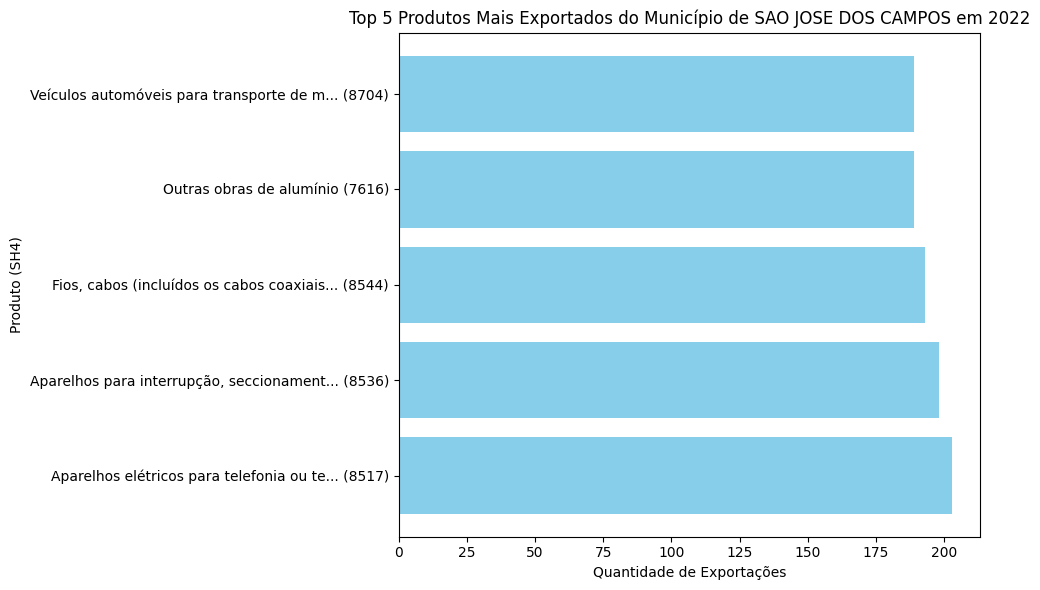

In [27]:
# Chamar a função inicial para mostrar o gráfico de um município de São Paulo em 2020
criar_grafico(dados_ano, municipios_sp_list[0], "2020")
